In [1]:
import pandas as pd
import seaborn as sns # data visualization library  
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt 
import math
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 50)

seed = 7
np.random.seed(seed)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_feature_filename = "dengue_features_train.csv"
train_label_filename = "dengue_labels_train.csv"

test_feature_filename = "dengue_features_test.csv"

train_features = pd.read_csv(train_feature_filename, index_col=[0,2])
test_features = pd.read_csv(test_feature_filename, index_col=[0,2])

train_labels = pd.read_csv(train_label_filename, index_col=[0,2])

train_features.fillna(method='ffill', inplace=True)
train_features['week_start_date'] = pd.to_datetime(train_features['week_start_date']).astype(np.int64) // 10**9

test_features.fillna(method='ffill', inplace=True)
test_features['week_start_date'] = pd.to_datetime(test_features['week_start_date']).astype(np.int64) // 10**9
test_features = test_features.astype('float32')

train_features = train_features.astype('float32')
train_labels = train_labels.astype('float32')

# for obs in range(1, 2):
#     train_features["T_" + str(obs)] = train_labels.total_cases.shift(obs)

# train_features.fillna(0.00, inplace=True)

features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']

train_features = train_features[features]
test_features = test_features[features]
train_features.head()
# train_labels.head()

reanalysis_specific_humidity_g_per_kg  \
city weekofyear                                          
sj   18                                      14.012857   
     19                                      15.372857   
     20                                      16.848572   
     21                                      16.672857   
     22                                      17.209999   

                 reanalysis_dew_point_temp_k  station_avg_temp_c  \
city weekofyear                                                    
sj   18                           292.414276           25.442858   
     19                           293.951416           26.714285   
     20                           295.434296           26.714285   
     21                           295.309998           27.471428   
     22                           295.821442           28.942858   

                 station_min_temp_c  
city weekofyear                      
sj   18                   20.000000  
     19                   22.200001  
     20                   22.799999  
     21                   23.299999  
     22                   23.900000

In [3]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']


sj_test_features = test_features.loc['sj']
sj_test_labels = test_features.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

# sj_train_features.head()

# normalize the dataset
scaler_labels = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

sj_train_labels = sj_train_labels.reset_index().drop(['weekofyear'], axis=1)
iq_train_labels = iq_train_labels.reset_index().drop(['weekofyear'], axis=1)

sj_train_features = scaler_features.fit_transform(sj_train_features)
sj_train_labels = scaler_labels.fit_transform(sj_train_labels)
iq_train_features = scaler_features.fit_transform(iq_train_features)
iq_train_labels = scaler_labels.fit_transform(iq_train_labels)


sj_test_features = scaler_features.fit_transform(sj_test_features)

sj_train_labels = np.delete(sj_train_labels, 0, 1)
# sj_train_labels



In [4]:
sj_train_X, sj_test_X, sj_train_y, sj_test_y = train_test_split(sj_train_features, sj_train_labels, test_size=0.25, random_state=0, shuffle=False)

iq_train_X, iq_test_X, iq_train_y, iq_test_y = train_test_split(iq_train_features, iq_train_labels, test_size=0.25, random_state=0, shuffle=False)

# sj_train_y

In [5]:
# # convert an array of values into a dataset matrix
# def create_dataset(x, y, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(x)-look_back-1):
#         a = x[i:(i+look_back), 0]
#         dataX.append(a)
#         dataY.append(y[i + look_back, 0])
#     return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
# look_back = 1
# sj_trainX, sj_trainY = create_dataset(sj_train_X, sj_train_y, look_back)
# sj_testX, sj_testY = create_dataset(sj_test_X, sj_test_y, look_back)

# sj_trainX.shape

sj_train_X = sj_train_X.reshape(sj_train_X.shape[0], 1, sj_train_X.shape[1])
sj_test_X = sj_test_X.reshape(sj_test_X.shape[0], 1, sj_test_X.shape[1])

sj_test = sj_test_features.reshape(sj_test_features.shape[0], 1, sj_test_features.shape[1])

Train on 702 samples, validate on 234 samples
Epoch 1/100
 - 1s - loss: 0.0179 - val_loss: 0.0040
Epoch 2/100
 - 0s - loss: 0.0151 - val_loss: 0.0048
Epoch 3/100
 - 0s - loss: 0.0150 - val_loss: 0.0048
Epoch 4/100
 - 0s - loss: 0.0150 - val_loss: 0.0050
Epoch 5/100
 - 0s - loss: 0.0150 - val_loss: 0.0050
Epoch 6/100
 - 0s - loss: 0.0150 - val_loss: 0.0049
Epoch 7/100
 - 0s - loss: 0.0149 - val_loss: 0.0050
Epoch 8/100
 - 0s - loss: 0.0150 - val_loss: 0.0052
Epoch 9/100
 - 0s - loss: 0.0149 - val_loss: 0.0048
Epoch 10/100
 - 0s - loss: 0.0149 - val_loss: 0.0050
Epoch 11/100
 - 0s - loss: 0.0149 - val_loss: 0.0049
Epoch 12/100
 - 0s - loss: 0.0149 - val_loss: 0.0046
Epoch 13/100
 - 0s - loss: 0.0148 - val_loss: 0.0043
Epoch 14/100
 - 0s - loss: 0.0149 - val_loss: 0.0047
Epoch 15/100
 - 0s - loss: 0.0148 - val_loss: 0.0049
Epoch 16/100
 - 0s - loss: 0.0148 - val_loss: 0.0050
Epoch 17/100
 - 0s - loss: 0.0148 - val_loss: 0.0043
Epoch 18/100
 - 0s - loss: 0.0148 - val_loss: 0.0047
Epoch 19/

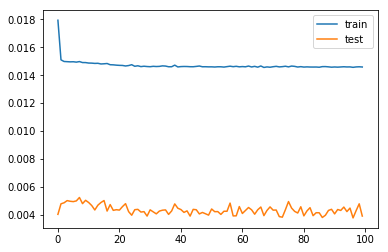

In [6]:
# create and fit the LSTM network
sj_model = Sequential()
sj_model.add(LSTM(4, input_shape=(1, 4), return_sequences=True))
sj_model.add(LSTM(1))
sj_model.add(Dense(1))

sj_model.compile(loss='mean_squared_error', optimizer='adam')
hist = sj_model.fit(sj_train_X, sj_train_y, epochs=100, batch_size=10, verbose=2,
          validation_data=(sj_test_X, sj_test_y))

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()


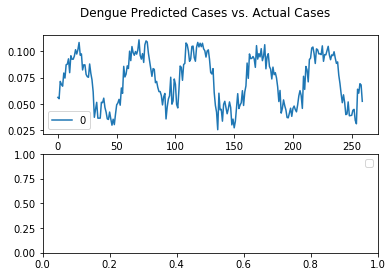

In [9]:
sj_pred = sj_model.predict(sj_test)
sj_pred = pd.DataFrame(sj_pred)
minn = sj_pred.min()
maxx = sj_pred.max()
dx = (maxx - minn)[0]
dx
# sj_pred = sj_pred.apply(lambda x : 10 * x / dx).astype(int)
sj_pred
benchmark = pd.read_csv('submission_vibodha_24.44.csv')

figs, axes = plt.subplots(nrows=2, ncols=1)

# benchmark.total_cases.plot(ax=axes[0], label="Predictions")
sj_pred.plot(ax=axes[0], label="Actual")
    
plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

plt.show()

# # # print("Comparison : MAE : " + str(mean_absolute_error(benchmark.total_cases, sj_pred)))